# Working with Text Data

In [1]:
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import warnings

from IPython.display import display
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

## Overview

이번장에서는 IMDB의 리뷰 데이터를 받아서 supervised learning, unsupervised learning 을 돌려봅니다. 아주 간단하게 맛만 보는 정도입니다.

## Types of Text Data

텍스트 데이터는 다음의 4종류가 있다고 하네요.

1. Categorical data
2. Free strings that can be semantically mapped to categories (e.g., typos or 'gray' and 'grey')
3. Structured string data
4. Text data

## Supervised Leaning: Bag of Words, TF-IDF, n-Grams, Lemmatization

IMDB의 리뷰 데이터를 받아서 다음의 분류방식들을 돌려보겠습니다. 분류 이후에는 Logistic regression 등의 supervised learning 방법을 사용합니다.

| 분류방법 | 설명 |
|--|--|
| Bag of Words (with Stopwords) | 문서들에서 모든 단어들을 뽑아내서, 각각 문서마다 어떤 단어들이 나왔는지를 sparse vector 로 표현 (자주 나오는 단어들은 stopwords로 걸러주고) |
| TF-IDF | "특정 문서에만 자주 나오는 단어들이 중요한것이다" 라는 직관에 의해, token frequency 가 작은 수의 문서들에 의해서만 자주나오는 것을 보정 |
| n-Grams | 한 단어가 아닌 연결된 단어/숙어가 중요하다는 것에 착안. Bag of Words를 여러 단어의 셋으로 확장 |
| Lemmatization | 영어는 ing형, 과거, 복수형등이 어렵게 만들므로, 그것들을 normalize 해서 카운팅하는 방법 |

In [2]:
# 우선 IMDB 데이터를 받고 압축을 풀어줍니다.
! test aclImdb_v1.tar.gz || wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
! test aclImdb || tar xvfz aclImdb_v1.tar.gz
! tree -dL 2 aclImdb

aclImdb
├── test
│   ├── neg
│   └── pos
└── train
    ├── neg
    └── pos

6 directories


In [3]:
! rm -r aclImdb/train/unsup/ 2>/dev/null

In [4]:
# 데이터를 불러옵니다.
from sklearn.datasets import load_files

reviews_train = load_files("aclImdb/train/")
text_train, y_train = reviews_train.data, reviews_train.target
print("type of text_train: {}".format(type(text_train)))
print("length of text_train: {}".format(len(text_train)))
print("text_train[6]:\n{}".format(text_train[6]))
text_train = [doc.replace(b"<br />", b" ") for doc in text_train]

type of text_train: <class 'list'>
length of text_train: 25000
text_train[6]:
b"This movie has a special way of telling the story, at first i found it rather odd as it jumped through time and I had no idea whats happening.<br /><br />Anyway the story line was although simple, but still very real and touching. You met someone the first time, you fell in love completely, but broke up at last and promoted a deadly agony. Who hasn't go through this? but we will never forget this kind of pain in our life. <br /><br />I would say i am rather touched as two actor has shown great performance in showing the love between the characters. I just wish that the story could be a happy ending."


In [5]:
reviews_test = load_files("aclImdb/test/")
text_test, y_test = reviews_test.data, reviews_test.target
print("Number of documents in test data: {}".format(len(text_test)))
print("Samples per class (test): {}".format(np.bincount(y_test)))
text_test = [doc.replace(b"<br />", b" ") for doc in text_test]

Number of documents in test data: 25000
Samples per class (test): [12500 12500]


### Bag of words

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
print("X_train:\n{}".format(repr(X_train)))

X_train:
<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3431196 stored elements in Compressed Sparse Row format>


In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, n_jobs=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.89
Best parameters:  {'C': 0.1}


In [8]:
X_test = vect.transform(text_test)
print("Test score: {:.2f}".format(grid.score(X_test, y_test)))

Test score: 0.88


In [9]:
vect = CountVectorizer(min_df=5, stop_words="english").fit(text_train)
X_train = vect.transform(text_train)
print("X_train with stop words:\n{}".format(repr(X_train)))

X_train with stop words:
<25000x26966 sparse matrix of type '<class 'numpy.int64'>'
	with 2149958 stored elements in Compressed Sparse Row format>


In [10]:
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, n_jobs=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.88


### TF-IDF

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None),
                     LogisticRegression())
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=5)
grid.fit(text_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.89


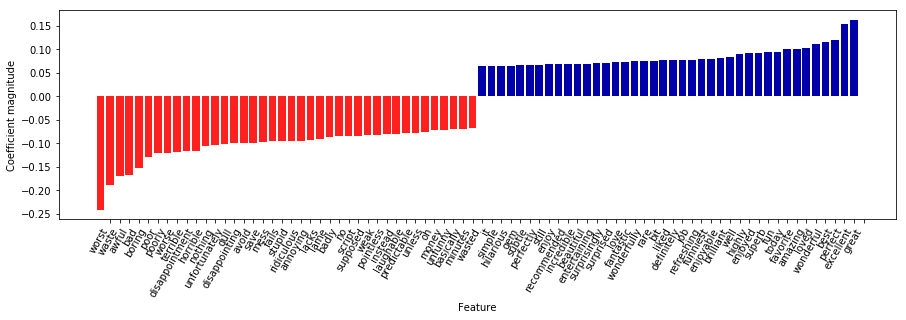

In [12]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
# transform the training dataset:
X_train = vectorizer.transform(text_train)
# find maximum value for each of the features over dataset:
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(vectorizer.get_feature_names())

mglearn.tools.visualize_coefficients(
    grid.best_estimator_.named_steps["logisticregression"].coef_,
    feature_names, n_top_features=40)

### n-Grams

In [13]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression())
# running the grid-search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
              "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}

grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=5)
grid.fit(text_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.91
Best parameters:
{'logisticregression__C': 100, 'tfidfvectorizer__ngram_range': (1, 3)}


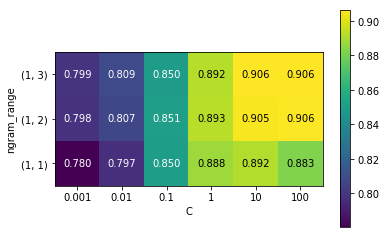

In [14]:
# extract scores from grid_search
scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T
# visualize heat map
heatmap = mglearn.tools.heatmap(
    scores, xlabel="C", ylabel="ngram_range", cmap="viridis", fmt="%.3f",
    xticklabels=param_grid['logisticregression__C'],
    yticklabels=param_grid['tfidfvectorizer__ngram_range'])
plt.colorbar(heatmap);

(-22, 22)

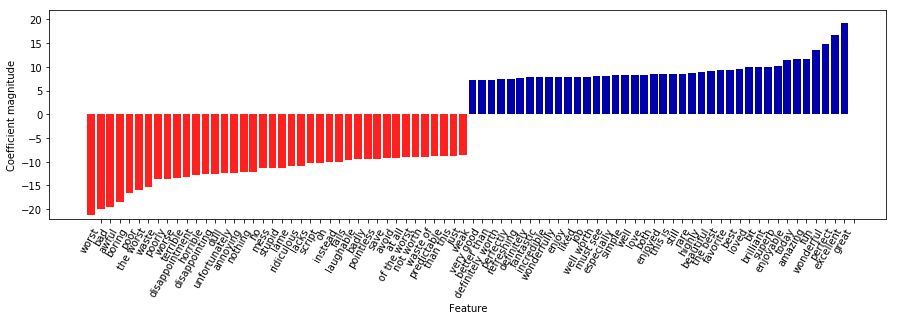

In [15]:
# extract feature names and coefficients
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names())
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=40)
plt.ylim(-22, 22)

### Lemmatization

In [17]:
import spacy
import nltk

# Technicallity: we want to use the regexp based tokenizer
# that is used by CountVectorizer  and only use the lemmatization
# from SpaCy. To this end, we replace en_nlp.tokenizer (the SpaCy tokenizer)
# with the regexp based tokenization
import re
# regexp used in CountVectorizer:
regexp = re.compile('(?u)\\b\\w\\w+\\b')
# load spacy language model - 만약 이게 안되면 python -m spacy download en 을 해보세요.
en_nlp = spacy.load('en', disable=['parser', 'ner'])
old_tokenizer = en_nlp.tokenizer
# replace the tokenizer with the preceding regexp
en_nlp.tokenizer = lambda string: old_tokenizer.tokens_from_list(
    regexp.findall(string))

# create a custom tokenizer using the SpaCy document processing pipeline
# (now using our own tokenizer)
def custom_tokenizer(document):
    doc_spacy = en_nlp(document)
    return [token.lemma_ for token in doc_spacy]

# define a count vectorizer with the custom tokenizer
lemma_vect = CountVectorizer(tokenizer=custom_tokenizer, min_df=5)

In [18]:
# transform text_train using CountVectorizer with lemmatization
X_train_lemma = lemma_vect.fit_transform(text_train)
print("X_train_lemma.shape: {}".format(X_train_lemma.shape))

# standard CountVectorizer for reference
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
print("X_train.shape: {}".format(X_train.shape))

X_train_lemma.shape: (25000, 21543)
X_train.shape: (25000, 27271)


In [19]:
# build a grid-search using only 1% of the data as training set:
from sklearn.model_selection import StratifiedShuffleSplit

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.99,
                            train_size=0.01, random_state=0)
grid = GridSearchCV(LogisticRegression(), param_grid, cv=cv, n_jobs=5)
# perform grid search with standard CountVectorizer
grid.fit(X_train, y_train)
print("Best cross-validation score "
      "(standard CountVectorizer): {:.3f}".format(grid.best_score_))
# perform grid search with Lemmatization
grid.fit(X_train_lemma, y_train)
print("Best cross-validation score "
      "(lemmatization): {:.3f}".format(grid.best_score_))

Best cross-validation score (standard CountVectorizer): 0.721
Best cross-validation score (lemmatization): 0.735


## Unsupervised Learning: Topic Modeling and Document Clustering

3장에서 배운 [PCA](03-dimensionality-reduction.ipynb)처럼 LDA도 토픽에 맞게 단어들을 나눠주는 테크닉입니다.

In [20]:
# 토픽을 우선 10개로 나눠봅니다.
vect = CountVectorizer(max_features=10000, max_df=.15)
X = vect.fit_transform(text_train)

In [21]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_topics=10, learning_method="batch",
                                max_iter=25, random_state=0)
# We build the model and transform the data in one step
# Computing transform takes some time,
# and we can save time by doing both at once
document_topics = lda.fit_transform(X)

# for each topic (a row in the components_), sort the features (ascending).
# Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
# get the feature names from the vectorizer:
feature_names = np.array(vect.get_feature_names())

In [22]:
mglearn.tools.print_topics(topics=range(10), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
between       war           funny         show          didn          
young         world         worst         series        saw           
family        us            comedy        episode       am            
real          our           thing         tv            thought       
performance   american      guy           episodes      years         
beautiful     documentary   re            shows         book          
work          history       stupid        season        watched       
each          new           actually      new           now           
both          own           nothing       television    dvd           
director      point         want          years         got           


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
horr

In [23]:
# 100개의 토픽으로 나눠봅니다.
lda100 = LatentDirichletAllocation(n_topics=100, learning_method="batch",
                                   max_iter=25, random_state=0)
document_topics100 = lda100.fit_transform(X)

topics = np.array([7, 16, 24, 25, 28, 36, 37, 41, 45, 51, 53, 54, 63, 89, 97])
sorting = np.argsort(lda100.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names())
mglearn.tools.print_topics(topics=topics, feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=20)

topic 7       topic 16      topic 24      topic 25      topic 28      
--------      --------      --------      --------      --------      
thriller      worst         german        car           beautiful     
suspense      awful         hitler        gets          young         
horror        boring        nazi          guy           old           
atmosphere    horrible      midnight      around        romantic      
mystery       stupid        joe           down          between       
house         thing         germany       kill          romance       
director      terrible      years         goes          wonderful     
quite         script        history       killed        heart         
bit           nothing       new           going         feel          
de            worse         modesty       house         year          
performances  waste         cowboy        away          each          
dark          pretty        jewish        head          french        
twist 

In [24]:
# 45번이 음악관련이네요.
# sort by weight of "music" topic 45
music = np.argsort(document_topics100[:, 45])[::-1]
# print the five documents where the topic is most important
for i in music[:10]:
    # show first two sentences
    print(b".".join(text_train[i].split(b".")[:2]) + b".\n")

b'I love this movie and never get tired of watching. The music in it is great.\n'
b"I enjoyed Still Crazy more than any film I have seen in years. A successful band from the 70's decide to give it another try.\n"
b'Hollywood Hotel was the last movie musical that Busby Berkeley directed for Warner Bros. His directing style had changed or evolved to the point that this film does not contain his signature overhead shots or huge production numbers with thousands of extras.\n'
b"What happens to washed up rock-n-roll stars in the late 1990's? They launch a comeback / reunion tour. At least, that's what the members of Strange Fruit, a (fictional) 70's stadium rock group do.\n"
b'As a big-time Prince fan of the last three to four years, I really can\'t believe I\'ve only just got round to watching "Purple Rain". The brand new 2-disc anniversary Special Edition led me to buy it.\n'
b"This film is worth seeing alone for Jared Harris' outstanding portrayal of John Lennon. It doesn't matter that H

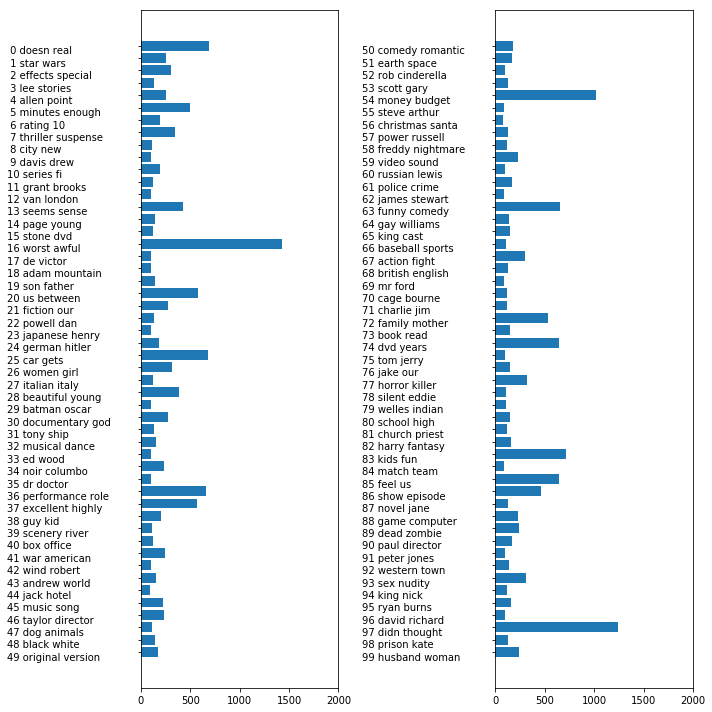

In [25]:
# 전체 토픽을 그려봅니다.
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
topic_names = ["{:>2} ".format(i) + " ".join(words)
               for i, words in enumerate(feature_names[sorting[:, :2]])]
# two column bar chart:
for col in [0, 1]:
    start = col * 50
    end = (col + 1) * 50
    ax[col].barh(np.arange(50), np.sum(document_topics100, axis=0)[start:end])
    ax[col].set_yticks(np.arange(50))
    ax[col].set_yticklabels(topic_names[start:end], ha="left", va="top")
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 2000)
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
plt.tight_layout();

## TODO

아무래도 이번 장은 큰 주제를 하나의 장에 담으려다보니 아주 겉핧기식으로만 진행되었습니다. 대신 마지막에 유용한 링크를 많이 남겨주셨네요.

| 주제 | 설명 |
|--|--|
| [Natuaral Language Processing with Python](https://www.amazon.com/Natural-Language-Processing-Python-Analyzing/dp/0596516495/) | 굉장히 좋은 책이라고 하는데요. [nltk](https://www.nltk.org/) 설명이 잘 나온다구요. 2009년 책이라 얼마나 유용할지 모르겠습니다. |
| [Introduction to Information Retrieval](https://nlp.stanford.edu/IR-book/) | IR관련 최고의 책인듯 합니다. |
| [nltk](https://www.nltk.org/), [spacy](https://spacy.io/), [gensim](https://radimrehurek.com/gensim/) | 파이썬 라이브러리들이구요. |
| [word2vec](https://en.wikipedia.org/wiki/Word2vec) | 2013년 NIPS에서 발표되어 표준처럼 쓰이고 있는 NLP 모델(?) 인듯 합니다. |
| RNN, LSTM, Tensorflow | NLP 관련 딥러닝 키워드들이구요. |
| [BERT](https://mino-park7.github.io/nlp/2018/12/12/bert-%EB%85%BC%EB%AC%B8%EC%A0%95%EB%A6%AC/) | BERT 는 2018년 구글에서 나온 딥러닝 기반 NLP 모델(?) 인 듯합니다. |